# Hyperparameter Integration and Model Selection with GPs 

This notebook code is mostly written on top of Alan's code in ccd and loo branch. They are two different branches on Github.

In [1]:
%matplotlib inline
import numpy as np
from pylab import *
from scipy import stats
# from builtins import range

In [2]:
np.set_printoptions(precision=4)

In [3]:
import paramz
import GPy

In [4]:
import matplotlib.pyplot as plt
import itertools
# import seaborn as sns

Test Model Selection by integrating out hyperparameters - A short demonstration
We will use grid integration, Laplace Approximation, MCMC and CCD integration 

In [5]:
SEED = 101
np.random.seed(SEED)

###  One dimensional data
We will perform ML inference first, followed by MAP inference and then finally integration of hyperparameters using different techniques available in GPy on a simple one dimensional regression task.

Select input data and make a simple GP Regression model

In [6]:
X = np.linspace(0,5,50)[:,None]
Y = np.sin(X)*3 + np.random.randn(*X.shape)*0.4 + 0.1

Set kernel, likelihood and inference objects as RBF, Gaussian and Laplace respectively - standard GP Regression 

In [7]:
k = GPy.kern.RBF(1)
lik = GPy.likelihoods.Gaussian()
laplace = GPy.inference.latent_function_inference.Laplace()

### MLE Inference
Inference of hyperparameters in this model with Maximum Likelihood Estimation(MLE) as we have no priors for the hyperparameters. Actually GPy internally constrains the parameters to be positive, which is also a kind of prior, but just to keep things simple here, we do a simple optimisation.



In [8]:
m_mle = GPy.core.GP(X.copy(), Y.copy(), k.copy(), lik.copy(), inference_method=laplace)

In [9]:
m_mle.optimize()

In [10]:
print(m_mle)
print(m_mle.param_array[:])
print(m_mle.optimizer_array[:])


Name : gp
Objective : 37.5765555355
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |  priors
  rbf.variance             |   4.67611366658  |      +ve      |        
  rbf.lengthscale          |   1.46211672252  |      +ve      |        
  Gaussian_noise.variance  |  0.161892839016  |      +ve      |        
[ 4.6761  1.4621  0.1619]
[ 4.6668  1.1985 -1.7388]


### Set up priors here ...

We will demonstrate several different priors avialable in GPy here. We can compare these priors when we do model comparison, in the second part of the notebook. 
What priors should we choose for the parameters of kernel function, for length scale: We can select Gaussian or Gamma priors. Inverse Gamma has also been used as a prior for the lengthscale parameter.
For signal variance, we could have Gaussian or Gamma priors. Signal magnitude(square root of signal variance) has a similar role to variance of weights of a linear model. As it can only be positive, we can use a half-t distribution, which has more mass in the tails than a half-normal distribution. GPStuff puts prior on signal magnitude and not signal variance. 
For a large lengthscale value, the GP tends to be a linear model anyways. 

In [11]:
gaussian_prior1 = GPy.priors.Gaussian(1.5, 0.08)
gaussian_prior2 = GPy.priors.Gaussian(1.58, 0.5)
gaussian_prior3 = GPy.priors.Gaussian(4.6, 1.)

In [12]:
gamma_prior1 = GPy.priors.Gamma.from_EV(1.5, 0.2)
gamma_prior2 = GPy.priors.Gamma.from_EV(1.5, 0.7)
# very general prior- non informative ..
gamma_prior3 = GPy.priors.Gamma.from_EV(1.0, 6.)

In [13]:
inv_gamma_prior1 = GPy.priors.InverseGamma(1.0, 0.2)
halft_prior1 = GPy.priors.HalfT(1.,1.)

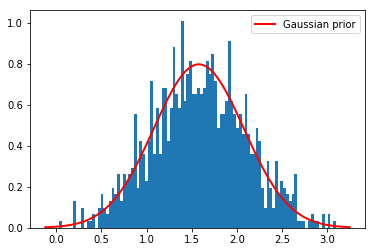

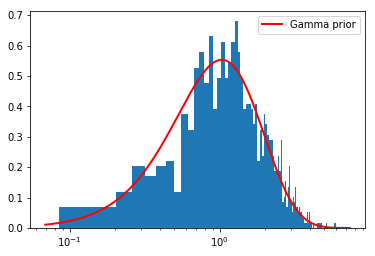

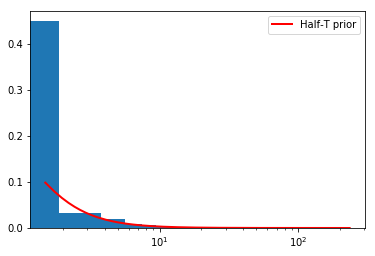

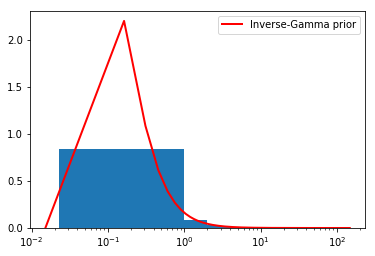

In [14]:
# plotting a gaussian prior
# figure, axes = plt.subplots(2,2, tight_layout=True)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
_ = gaussian_prior2.plot()
ax1.legend(['Gaussian prior'])

# plotting a gamma prior with log scale
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_xscale('log')
_= gamma_prior2.plot()
ax2.legend(['Gamma prior'])

# plottting a half-t prior with log scale
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.set_xscale('log')
_= halft_prior1.plot()
ax3.legend(['Half-T prior'])

#  plotting a inverse-gamma prior with log scale
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.set_xscale('log')
_= inv_gamma_prior1.plot()
ax4.legend(['Inverse-Gamma prior'])


In [15]:
m_map = GPy.core.GP(X.copy(), Y.copy(), k.copy(), lik.copy(), inference_method=laplace)

### MAP Inference
Inference of hyperparameters through MAP(Maximise aposteriori) for these models. Here we will set up a prior on the lengthscale and noise variance. The model is sensitive to the choice of priors. We will pick two priors: one with a very small width, so it is almost equivalent to ML inference, and the second prior has a wider width.
$$ p(\theta|D) \propto p(D| \theta)p(\theta) $$
$$ \log p(\theta|D) =  \log p(D| \theta) + \log p(\theta) - Constant$$
$$ \hat{\theta}, \hat{\phi} = \mathop{\mathrm{argmax}}_{\theta} p(\theta|D), \mathop{\mathrm{argmax}}_{\phi} p(\phi|D)$$
where $\theta$ represents parameters of kernel function like lengthscale, and $\phi$ represents parameters of likelihood function like variance.

In [16]:
# m2.unconstrain()
m_map.kern.lengthscale.unconstrain()
m_map['.*Gaussian_noise'].unconstrain()
m_map['.*variance'].unconstrain()
m_map.kern.lengthscale.set_prior(gaussian_prior2)

In [17]:
print(m_map[''])
m_map.checkgrad()

  index  |             gp.rbf.variance  |  constraints  |    priors   
  [0]    |                      1.0000  |               |             
  -----  |          gp.rbf.lengthscale  |  -----------  |  -----------
  [0]    |                      1.0000  |               |  N(1.6, 0.5)
  -----  |  gp.Gaussian_noise.variance  |  -----------  |  -----------
  [0]    |                      1.0000  |               |             


True

In [18]:
m_map.optimize()

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


In [19]:
print(m_map)
print(m_map.log_likelihood())
# print(m2._objective())


Name : gp
Objective : 40.6563983944
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |    priors   
  rbf.variance             |   1.24370017526  |               |             
  rbf.lengthscale          |   1.20384959387  |               |  N(1.6, 0.5)
  Gaussian_noise.variance  |  0.176271946793  |               |             
-40.1476287857


In [20]:
modal_point = m_map.param_array[:].copy()

In [21]:
print(m_map.log_likelihood())
print(m_map)

-40.1476287857

Name : gp
Objective : 40.6563983944
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |    priors   
  rbf.variance             |   1.24370017526  |               |             
  rbf.lengthscale          |   1.20384959387  |               |  N(1.6, 0.5)
  Gaussian_noise.variance  |  0.176271946793  |               |             


Here, dont unconstrain the parameters and just do the optimisation after fixing the noise variance. 

In [22]:
m_map2 = GPy.core.GP(X.copy(), Y.copy(), k.copy(), lik.copy(), inference_method=laplace)

In [23]:
m_map2['.*Gaussian_noise'] = 0.15
m_map2['.*Gaussian_noise'].fix()
m_map2.kern.lengthscale.unconstrain()
m_map2.kern.variance.unconstrain()
# m_map2['.*variance'].unconstrain()
m_map2.kern.lengthscale.set_prior(gaussian_prior2)
m_map2.kern.variance.set_prior(gaussian_prior3)
print(m_map2)


Name : gp
Objective : 49.6217526289
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.                      |  value  |  constraints  |    priors   
  rbf.variance             |    1.0  |               |   N(4.6, 1) 
  rbf.lengthscale          |    1.0  |               |  N(1.6, 0.5)
  Gaussian_noise.variance  |   0.15  |   fixed +ve   |             


In [24]:
m_map2.optimize()

In [25]:
print(m_map2)


Name : gp
Objective : 38.8125684204
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.                      |          value  |  constraints  |    priors   
  rbf.variance             |  4.62374210185  |               |   N(4.6, 1) 
  rbf.lengthscale          |  1.48190166503  |               |  N(1.6, 0.5)
  Gaussian_noise.variance  |           0.15  |   fixed +ve   |             


### Hyperparameter integration 
To take into account the full uncertainity of the hyperparameters, we need to integrate over them. We will cover this with MCMC sampling, grid integration, laplace approximation and CCD. The marginal posterior of the latent values can be  written as:

$$p(\textbf{f}|D) = \int p(\textbf{f},\theta|D)d\theta = \frac{1}{Z}\int p(y|\textbf{f})p(\textbf{f}|X, \theta)p(\theta)d\theta $$
where $f$ is the vector of latent values, Z is the normalization constant given as $$Z = \int \int p(y|\textbf{f})p(\textbf{f}|X, \theta)p(\theta)d\theta df$$, and $D=(X,Y)$ is the set of training input and training outputs. If we change the order of integration and integrate out  $ \textbf{f}$ first, then we get an estimate of marginal likelhood, which we use for standard GP regression.

Integration over hyperparameter space is intractable, so we can use an approximation through finite sum:
 $$  p(f|D) \approx \sum_{i=1}^{M} p(\textbf{f}|D, \gamma_{i}) p(\gamma_{i}|D) \delta_{i}  $$
 where $\gamma_{i}$ represents log transformation of $\theta_{i}$ and $\delta_{i}$ is the area(voulme) weight contributed by the evaluation point in transformed hyperparameter space $\gamma_{i}$. 


### Integration with HMC

Code used from here: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb

In [26]:
m_hmc = GPy.core.GP(X, Y,  k.copy(), lik.copy(), inference_method=laplace)

In [27]:
m_hmc2 = m_hmc.copy()

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


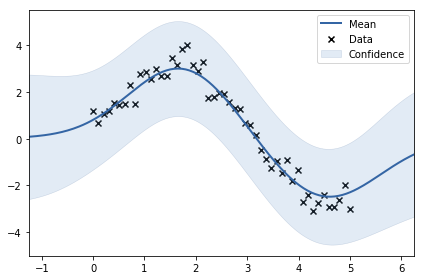

In [28]:
# m_hmc.unconstrain()
m_hmc.kern.lengthscale.set_prior(gamma_prior3)
m_hmc.kern.variance.set_prior(gamma_prior3)
m_hmc.likelihood.variance.set_prior(gamma_prior3)
_=m_hmc.plot()

Do the inference with MCMC and plot the samples 

In [29]:
hmc = GPy.inference.mcmc.HMC(m_hmc, stepsize=5e-2)
# Burnin
s = hmc.sample(num_samples=1000)
s = hmc.sample(num_samples=2000)

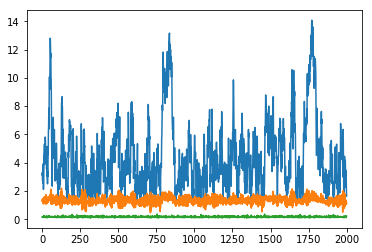

In [30]:
plot(s)

Now plot the marginal posterior distributions of model parameters:

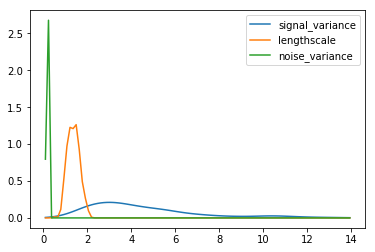

In [31]:
labels = ['signal_variance' , 'lengthscale', 'noise_variance']
# Remove burnin
samples = s[500:]
# thinning
samples = samples[::2]
xmin = samples.min()
xmax = samples.max()
xs = np.linspace(xmin, xmax, 100)
for i in xrange(samples.shape[1]):
    kernel = stats.gaussian_kde(samples[:,i])
    plot(xs,kernel(xs),label=labels[i])
_ = legend()


Plot the samples of lengthscale, noise variance and sigmal variance against each other two at a time.

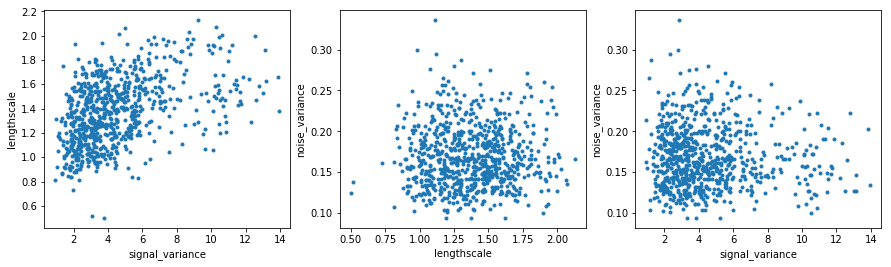

In [32]:
fig = figure(figsize=(15,4))
ax = fig.add_subplot(131)
_=ax.plot(samples[:,0],samples[:,1],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[1])
ax = fig.add_subplot(132)
_=ax.plot(samples[:,1],samples[:,2],'.')
ax.set_xlabel(labels[1]); ax.set_ylabel(labels[2])
ax = fig.add_subplot(133)
_=ax.plot(samples[:,0],samples[:,2],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[2])

In [33]:
mean_values = np.mean(samples, axis=0)


Name : gp
Objective : 46.8898758385
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |      priors    
  rbf.variance             |   4.50025577986  |      +ve      |  Ga(0.17, 0.17)
  rbf.lengthscale          |   1.36989053548  |      +ve      |  Ga(0.17, 0.17)
  Gaussian_noise.variance  |  0.168944295608  |      +ve      |  Ga(0.17, 0.17)


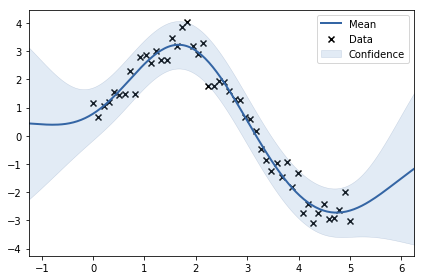

In [34]:
# set the model parameters at the posterior mean
m_hmc.kern.variance[:] = mean_values[0]
m_hmc.kern.lengthscale[:] = mean_values[1]
m_hmc.likelihood.variance[:] = mean_values[2]
print(m_hmc)
m_hmc.plot()

### HMC sampling with fixed noise variance to get joint posterior on signal variance and lengthscale.
Fix the noise variance, and do HMC sampling again so that we can get a joint posterior on lengthscale, and signal variance

In [35]:
m_hmc2['.*Gaussian_noise'] = 0.15
m_hmc2['.*Gaussian_noise'].fix()

In [36]:
hmc2 = GPy.inference.mcmc.HMC(m_hmc2, stepsize=5e-2)
# Burnin
s = hmc2.sample(num_samples=1000)
s = hmc2.sample(num_samples=2000)

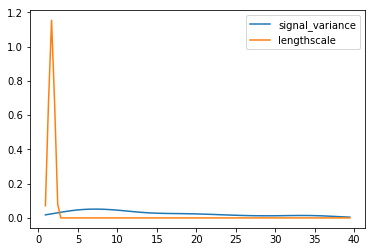

In [37]:
labels = ['signal_variance' , 'lengthscale', 'noise_variance']
# Remove burnin
samples = s[500:]
# thinning
samples = samples[::2]
xmin = samples.min()
xmax = samples.max()
xs = np.linspace(xmin, xmax, 100)
for i in xrange(samples.shape[1]):
    kernel = stats.gaussian_kde(samples[:,i])
    plot(xs,kernel(xs),label=labels[i])
_ = legend()

Plotting hmc samples for joint posterior distribution of - lengthscale and signal_variace parameters. 
That is how the posterior $p(\theta|X, Y)$ looks.

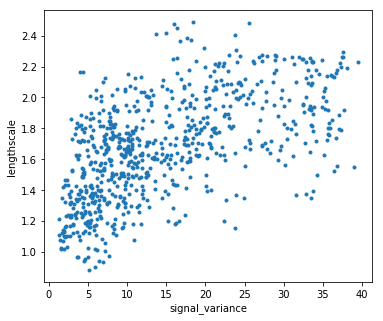

In [38]:
fig = figure(figsize=(20,5))
ax = fig.add_subplot(131)
_=ax.plot(samples[:,0],samples[:,1],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[1])

The above plot does not look so Gaussian, so we could transform the parameters to log space, and the resulting posterior distributions generally look more Gaussian as shown in [2]. 

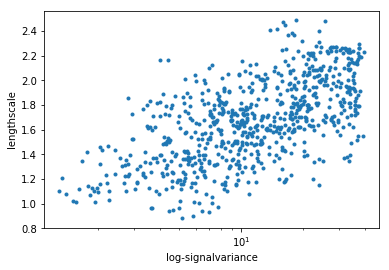

In [39]:
loglabels = ['log-signalvariance', 'lengthscale']
fig = plt.figure()
ax = fig.add_subplot(111)
_=ax.semilogx(samples[:,0],samples[:,1],'.')
ax.set_xlabel(loglabels[0]); ax.set_ylabel(loglabels[1])
# ax.legend([''])

In [41]:
print samples.shape
thin_samples = samples[::7,:]
print thin_samples.shape

(750, 2)
(108, 2)


In [42]:
logexp_trans = GPy.constraints.Logexp()

### Plotting the principle components of the log posterior distribution of hyperparams.

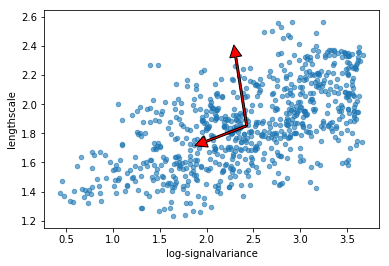

In [47]:
# samp_plot = samples[:,:2].copy()
# First transform the parameters to optimizer space and then do a log transformation ... 
N = samples.shape[0]
samp_plot = logexp_trans.f(samples[:,:2].copy())
samp_plot[:,0] = np.log(samp_plot[:,0])

xData = samp_plot[:,0].reshape((N,1))
yData = samp_plot[:,1].reshape((N,1))
data = np.hstack((xData, yData))
mu = data.mean(axis=0)
data = data - mu 

# calculate the eigen vectors and eigen values of the samples.
eigenvectors, eigenvalues, V = np.linalg.svd(data.T, full_matrices=False)
projected_data = np.dot(data, eigenvectors)
sigma = projected_data.std(axis=(0,1)).mean()
# print sigma
# print(eigenvectors)
# 


fig, ax = plt.subplots()
ax.scatter(xData, yData, alpha=0.6, s=20)
for axis in eigenvectors:
    start, end = mu, mu + sigma * axis
    ax.annotate(
        '', xy=end, xycoords='data',
        xytext=start, textcoords='data',
        arrowprops=dict(facecolor='red', width=2.0))
# ax.set_aspect('equal')
ax.set_xlabel(loglabels[0]); ax.set_ylabel(loglabels[1])

plt.show()

In [48]:
# @TODO: make a contour plot of marginal likelihood at the HMC samples.
obj = np.zeros((thin_samples.shape[0],1))
noise_param = 0.15
noise_param_opt = logexp_trans.f(noise_param)

print samples.shape
noise_vector = np.ones((samples.shape[0], 1)) * noise_param_opt
samples = np.concatenate((samples, noise_vector), axis=1)
print samples.shape
print noise_param, noise_param_opt


(750, 3)
(750, 4)
0.15 0.77095704779


In [49]:
i = 0
obj = []
for s in samples:
    s_opt = logexp_trans.f(s)
    val= m_hmc2._objective(s_opt)
    obj.append(val)
    i = i+1


In [50]:
obj2 = np.array(obj)[None,:]

In [ ]:
# fig = plt.figure()
# cs = plt.contour(samples[:,0], samples[:,1], obj2)
# plt.clabel(CS, inline=1, fontsize=10)
# plt.title('Simplest default with labels')

In [52]:
m_hmc2.log_likelihood()

-40.419452537858874

### Grid Integration
 
Grid Integration is a brute force way of doing the integration over the parameter space. We use a grid of length N distributed uniformly in a D-dimensional parameter space, which will require $N^{D}$ points and hence $N^{D}$  number of evaluations. This is exponential growth. Unless N is very large, the volume covered by each grid point will become too large and thus will not really be representative of the volume, and even with so much computation power thrown at it, the results could still be poor.

It is better to do grid integration in log space as described above, but in this case, we will do it in the original space.

In [53]:
def gridIntegration(m, rangemin, rangemax, stepsize=0.1, optimize=True):
#     make sure that m is at mode - calculate marginal likelihood at gridpoints around mode, and then sum them up.  
    if optimize:
        m.optimize()
    modal_params = m.param_array[:].copy()
    optim_params = m.optimizer_array[None,:].copy()
    param_ranges = []
    for p in optim_params[0]:
        param_ranges.append(np.arange(rangemin, rangemax, stepsize))
    grids = itertools.product(*param_ranges)
    liksum = 0
    for el in grids:
        liksum += np.exp(-m._objective(el))
    return liksum*(stepsize**len(optim_params[0]))

Small note on Implementation details:
Be careful with the param_array and optimizer_array as they are two different entities. Optimizer_array contains only the unfixed and tranformed values, on which the actual optimizer works on, while the param_array contains all the parameter values associated with the model, the end user-(person who is doing modelling and setting up priors) sees. For example, if we put a constraint that a particular parameter should be positive, then GPy internally does a LogExp transformation to map it to optimizer space, and once optimisation is done , transforms it back to the param space with ExpLog transformation. 

In [120]:
grid_sum = gridIntegration(m_map2, rangemin=0.001, rangemax=20, stepsize=0.2)

### Laplace Integration
Integration by laplace Approximation - fit a gaussian at modal value given by $\frac{1}{2\pi} m_0|H^{-1}|$  where $m_0$ is the marginal likelihood at the mode of hyperparameters, and H is the hessian matrix at the mode.

In [55]:
def lapIntegration(m, optimize=True):
    if optimize:
        m.optimize()
    hessian = m.numerical_parameter_hessian()
    #   calculating hessian moves the model away from the mode and we need to get back to mode.
    m.optimize()
    lap_sum = np.exp(-m._objective(m.param_array[:]))*1/np.sqrt(np.linalg.det(1/(2*np.pi)*hessian))
    return lap_sum

In [56]:
lap_sum = lapIntegration(m_map2)

In [57]:
print  lap_sum

2.10462182671e-17


### CCD Integration
In the above plots, where we drew the principle components of the joint posterior, the components were centred at the mean value of the samples. But here, we will use the mode of the posterior and assuming that the posterior density is a Gaussian, we will select some points deterministically and calculate their integration weights based on the volume mass they represent. This is effectively deterministic MC integration. Rue et al. (2009) suggest a central composite design (CCD) for choosing the representative points from the posterior distribution of the hyperparams. The design is given in Sanchez and Sanchez 2005[4]. The integration is then reduced to a finite sum with special weights. The integration weights can be easily derived using the properties of a multivariate random variable with Gaussian distribution. 

In [58]:
m_map2.optimize()
print(m_map2.param_array, m_map2.optimizer_array)

(array([ 4.6238,  1.4819,  0.15  ]), array([ 4.6238,  1.4819]))


In [59]:
# hessum = np.exp(-m2._objective(m2.param_array))*1/np.sqrt(np.linalg.det(1/(2*np.pi)*hes))         
ccdpos,ccddensity,scalings,z = m_map2.CCD()

The ccdpos variable gives the positions of the ccd points, ccddensity gives the values $p(\gamma_{i}|D) \delta_{i}$ that is the product of posterior density and integration weight.

The ccdpos variable gives the positions of the points, ccddenisty gives the weighted density of the CCD points, where the first point in the list is the central point. The centre point will always be given the weight 1, and other points are scaled accordingly. 

In [60]:
print "scalings:", scalings
print "cdd points coordinates:", ccdpos
print "weight density at those points:", ccddensity
print "z:", z
# ccdpos,ccdres,scalings,z = m2.CCD()

scalings: [[ 1.      1.    ]
 [ 1.0115  0.8745]
 [ 0.9775  0.8745]
 [ 1.0115  1.0585]
 [ 0.9775  1.0585]
 [ 1.0115  1.    ]
 [ 0.9775  1.    ]
 [ 1.      0.8745]
 [ 1.      1.0585]]
cdd points coordinates: [[ 4.6238  1.4819]
 [ 5.6755  1.7772]
 [ 3.5833  1.671 ]
 [ 5.7025  1.2438]
 [ 3.6103  1.1377]
 [ 6.1284  1.5583]
 [ 3.1696  1.4081]
 [ 4.6065  1.8232]
 [ 4.6447  1.0689]]
weight density at those points: [ 0.1726  0.1049  0.1034  0.1083  0.1051  0.1029  0.1021  0.1038  0.097 ]
z: [[ 0.9563  0.0485]
 [-0.0127  0.2508]]


### Calculate the evidence values at the ccd design points of the ellipsoid and sort them according to value of evidence. 

In [103]:
evidence = np.zeros((ccdpos.shape[0], 1))
for i, pt in enumerate(ccdpos):
    evidence[i] = m_map2._objective(pt)
    
evidence = -evidence
print(evidence)
ind = np.argsort(evidence, axis=0)
ind = ind.flatten()
ccdpos_plot = ccdpos[ind,:]
# print(ccdpos_plot)

[[-38.8126]
 [-40.001 ]
 [-40.0163]
 [-39.9694]
 [-39.9996]
 [-40.0204]
 [-40.0288]
 [-40.0125]
 [-40.0803]]


### Plot of CCD points

The design points are at a distance of $\sqrt{d}f_{0}$ where $d$ is the dimensionality and $f_{0}$ is a constant greater than 1.0 .
Plotting CCD Points in the parameter space, the resulting plot looks like an ellipsoid after the initial sphere around the mode is reparameterised in to the parameter space. The plot is in rainbow format, with the highest density being red(centre point and the mode) and so on. Please consult [1] for further details.

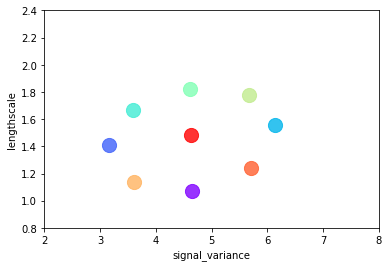

In [107]:
fig, ax = plt.subplots()
xs = ccdpos_plot[:,0]
ys = ccdpos_plot[:,1]
colors = cm.rainbow(np.linspace(0, 1, len(ccdpos_plot)))
for x, y, c in zip(xs, ys, colors):
    ax.scatter(x, y, alpha=0.8, color=c, s=200)
# ax.scatter(ccdpos[:,0], ccdpos[:,1], alpha=0.8, s=40)
ax.set_xlim((2,8))
ax.set_ylim((0.8,2.4))
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[1])

Final values of all the integration techniques:

In [122]:
ccdsum = 0.
for pos, density in zip(ccdpos, ccddensity):
    ccdsum += density*np.exp(-m_map2._objective(pos))
print "ccd sum:", ccdsum
print "laplace int sum:", lap_sum
print "Grid sum:", grid_sum

ccd sum: 5.86731145342e-18
laplace int sum: 2.10462182671e-17
Grid sum: 1.98245968551e-17


## Model Selection


Compare different priors with LOO score or Hyperparameter integration.

### LOO
The marginal likelihood given by integrating out latent value $\textbf{f}$ is given as :
$$ P(Y^{*}|X, \theta)$$ 
This serves as the objective for tuning the parameters of the covariance function and likelihood function. However for model selection and evaluation the LOO-CV could be considered as criterion for selection. LOO-CV is basically the predictive score for each data point y when considered in isolation as test point using the rest of the data for training. The  difference to marginal likelihood is that each point y is considered seperately. 
$$ \mathrm{LOO} = \sum_{i=1}^{N}P(y_{i}^{*}| X, Y_{-i}, \theta ) $$

Below, we compare the LOO score of the two models we considered above. Model with map inference on all parameters has slightly better performance than model with MLE inference and model with map inference but noise parameter fixed.

In [66]:
print(np.sum(m_mle.LOO()))
print(np.sum(m_map.LOO()))
print(np.sum(m_map2.LOO()))

-28.5482683696
-28.2977769917
-28.7893283236


### Model Selection with LOO on Mauna-Loa dataset(Some bug with the code, so generates NAN values)
Use different kernel functions sequentially and check the LOO values.

In [67]:
import pods

In [68]:
data = pods.datasets.mauna_loa()

Using cached version of the data set, to use latest version set refresh_data to True
Most recent data observation from month  7.0  in year  2017.0


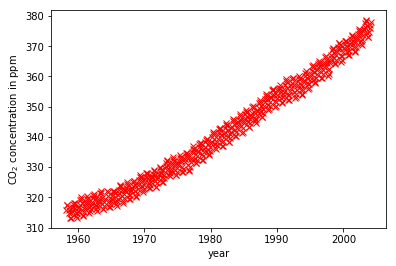

In [69]:
plt.plot(data['X'], data['Y'], 'rx')
plt.xlabel('year')
plt.ylabel('CO$_2$ concentration in ppm')

In [70]:
print(data['citation'])
print(data['info'])

Mauna Loa Data. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).
Mauna Loa data with 545 values used as training points.


In [71]:
X_CO2 = data['X']
Y_CO2 = data['Y']

Make kernel object here with different components representing periodicity, seasonal and long term trends.
Use values in GPML book !!

In [72]:
k_long_term  = GPy.kern.RBF(input_dim=1, variance=66.0, lengthscale=67.0)
k_seasonal = GPy.kern.RBF(input_dim=1, variance=2.4, lengthscale=90.0)* GPy.kern.StdPeriodic(input_dim=1, lengthscale=1.3, period=1.0, active_dims=[0]) 
k_medium = GPy.kern.RatQuad(input_dim=1, variance=0.66, lengthscale=1.2, power=0.78)
k_noise = GPy.kern.RBF(input_dim=1, lengthscale=0.134, variance=0.18) + GPy.kern.White(input_dim=1, variance=0.19**2)
# k_long_term = GPy.kern.RBF(input_dim=1, variance=50.0, lengthscale=50.0)
# k_seasonal = GPy.kern.RBF(input_dim=1, variance=2.0, lengthscale=100.0) * GPy.kern.StdPeriodic(input_dim=1, lengthscale=1.3, period=1.0, active_dims=[0]) 
# k_medium = GPy.kern.RatQuad(input_dim=1, variance=0.5, lengthscale=1.0, power=1.0)
# k_noise = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=0.1) + GPy.kern.White(input_dim=1, variance=0.1**2)
k1 = GPy.kern.RBF(1,variance=66.0, lengthscale=67.0)
k2 = GPy.kern.StdPeriodic(1, lengthscale=1.3, period=1.0) * GPy.kern.RBF(1, lengthscale=90.0, variance=2.4) 
k3 = GPy.kern.RatQuad(1,lengthscale=1.2,power=0.78, variance=0.66)
k4 = GPy.kern.RBF(1,lengthscale= 0.134, variance=0.18) + GPy.kern.White(1,variance=0.19**2)


In [73]:
Gaussian = GPy.likelihoods.Gaussian(variance=1e-3)

In [74]:
# this does not work !!
# k_all = k_long_term.copy() + k_seasonal.copy() + k_medium.copy() + k_noise.copy()

In [75]:
k_rasmussen = GPy.kern.Add([k_long_term.copy(),k_seasonal.copy(),k_medium.copy(),k_noise.copy()])
k_ras2 = GPy.kern.Add([k1.copy(),k2.copy(),k3.copy(),k4.copy()])

In [76]:
k_nonseasonal = GPy.kern.Add([k_long_term.copy(),k_medium.copy(),k_noise.copy()])

In [77]:
k_non_longterm = GPy.kern.Add([k_seasonal.copy(),k_medium.copy(),k_noise.copy()])

First model with all kernels and then remove them one by one.

In [78]:
m_co2_rasmus = GPy.core.GP(X_CO2, Y_CO2, kernel=k_ras2, likelihood=Gaussian.copy(), inference_method=laplace)

In [79]:
m_co2_rasmus.optimize()

In [80]:
print(m_co2_rasmus[''])

  index  |                  gp.sum.rbf.variance  |  constraints  |  priors
  [0]    |                              66.0000  |      +ve      |        
  -----  |               gp.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                              67.0000  |      +ve      |        
  -----  |     gp.sum.mul.std_periodic.variance  |  -----------  |  ------
  [0]    |                               1.0000  |      +ve      |        
  -----  |       gp.sum.mul.std_periodic.period  |  -----------  |  ------
  [0]    |                               0.9997  |      +ve      |        
  -----  |  gp.sum.mul.std_periodic.lengthscale  |  -----------  |  ------
  [0]    |                               1.3000  |      +ve      |        
  -----  |              gp.sum.mul.rbf.variance  |  -----------  |  ------
  [0]    |                               2.4000  |      +ve      |        
  -----  |           gp.sum.mul.rbf.lengthscale  |  -----------  |  ------
  [0]    |               

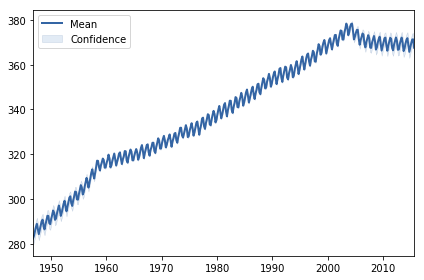

In [81]:
m_co2_rasmus.plot(plot_raw=True, resolution=400)

In [82]:
transf = GPy.constraints.Exponent()
log_trans = GPy.constraints.Log()
logexp_trans = GPy.constraints.Logexp()

In [83]:
# m1['rbf.lengthscale'].constrain(transf)

## References
1. Jarno Vanhatalo, Ville Pietiläinen, and Aki Vehtari. 2010. Approximate inference
for disease mapping with sparse Gaussian processes. Statistics in Medicine,
volume 29, number 15, pages 1580-1607.

2. Rue, Håvard, Sara Martino, and Nicolas Chopin. "Approximate Bayesian inference for latent Gaussian models by using integrated nested Laplace approximations." Journal of the royal statistical society: Series b (statistical methodology) 71.2 (2009): 319-392. http://www.jstor.org/stable/40247579

3. Notebook on HMC in GPy- http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb

4. Sanchez, Susan M., and Paul J. Sanchez. "Very large fractional factorial and central composite designs." ACM Transactions on Modeling and Computer Simulation (TOMACS) 15.4 (2005): 362-377.

